<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Решетников Дмитрий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center> Неделя 7.  Отчет о выполненном проекте

**План 7 недели:**
- цели и задачи проекта, описание исходных и обработанных данных и признаков.
- первичный анализ признаков
- первичный визуальный анализ признаков
- описание предобработки данных
- если создаются признаки, то описание этого процесса
- кросс-валидация, построение кривых валидации и обучения
- оценка модели с описанием выбранной метрики. Опишите простыми словами качество модели, как она может применяться
- выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.

# Цели и задачи проекта
описание исходных и обработанных данных и признаков.

Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.



## Загрузим тренировочные и тестовые данные

In [12]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from matplotlib import pyplot as plt

In [13]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('/Users/dreshetnikov/Documents/Projects/iCrossing2/course6/capstone_user_identification/')

In [14]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA,'train_sessions_new.csv'), 
                           index_col='session_id')

In [15]:
test_df = pd.read_csv(os.path.join(PATH_TO_DATA,'test_sessions_new.csv'), 
                           index_col='session_id')

Объединим тренировочную и тестовые выборки

In [16]:
train_test_df = pd.concat([train_df, test_df])

In [17]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

### Выделим переменные

In [18]:
def create_csr_matrix(data):
    indexes = [0]
    vals = []
    column_indexes = []
    index = 0
    for i in range(0,data.shape[0]):
        for j in range(0, data.shape[1]):
            if data[i,j] != 0:
                column_indexes.append(data[i,j])
                vals.append(1)
                index+=1
        indexes.append(index)
    return csr_matrix((vals, column_indexes, indexes))[:,1:]

train_test_sparse = create_csr_matrix(train_test_df_sites.as_matrix())
X_train_sparse = train_test_sparse[:253561]
X_test_sparse = train_test_sparse[253561:]
y = train_df['target'].as_matrix()

In [19]:
enriched_df = pd.DataFrame()

In [20]:
%%time
enriched_df['#uniqe_sites'] = train_test_df_sites.apply(lambda x: len(np.unique(x[:10])), axis=1)

CPU times: user 1min 11s, sys: 732 ms, total: 1min 12s
Wall time: 1min 13s


In [21]:
%%time
counter = train_test_df_sites.stack().value_counts()
top_sites = counter[1:50].index
def count_popular(row):
    return len(set(row[:10]) & set(top_sites))

enriched_df['top_sites_visited'] = train_test_df_sites.apply(count_popular, axis=1)

CPU times: user 1min 12s, sys: 593 ms, total: 1min 13s
Wall time: 1min 14s


In [22]:
%%time
def get_start_hour(x):
    return datetime.strptime(x[0], "%Y-%m-%d %H:%M:%S").hour

enriched_df['start_hour'] = train_test_df[['time1']].apply(get_start_hour, axis=1)

CPU times: user 28 s, sys: 189 ms, total: 28.2 s
Wall time: 28.7 s


In [23]:
%%time
def get_start_day_of_week(x):
    return datetime.strptime(x[0], "%Y-%m-%d %H:%M:%S").weekday()
enriched_df['day_of_week'] = train_test_df[['time1']].apply(get_start_day_of_week, axis=1)

CPU times: user 24.5 s, sys: 172 ms, total: 24.7 s
Wall time: 24.9 s


In [24]:
%%time
def get_session_timespan(row):
    start_time = row[0];
    end_time = row[0];
    for r in row:
        if r == 0:
            continue
        end_time = r
    start_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
    end_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    return (end_time - start_time).total_seconds()

enriched_df['ses_timespan'] = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(0).apply(get_session_timespan, axis=1)

CPU times: user 55.2 s, sys: 645 ms, total: 55.9 s
Wall time: 59.6 s


In [25]:
%%time
def get_visits_time(row):
    start_time = row[0];
    end_time = row[0];
    res = []
    for r in row:
        if r == 0:
            break
        start_time = end_time
        end_time = r
        s_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
        e_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
        res.append((e_time - s_time).total_seconds())
    while(len(res) < 10):
        res.append(0)
    return res[1],res[2],res[3],res[4],res[5],res[6],res[7],res[8],res[9]

temp = list(zip(*train_test_df[['time%d' % i for i in range(1, 11)]].fillna(0).apply(get_visits_time, axis=1)))
for i, c in enumerate(['time_diff%d' % i for i in range(1, 10)]):
    enriched_df[c] = temp[i]

CPU times: user 3min 16s, sys: 1.05 s, total: 3min 17s
Wall time: 3min 18s
Compiler : 164 ms


In [26]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 12))

for idx, colname in  enumerate(enriched_df.columns): 
    ax = axes[int(idx/3)][idx%3]
    ax.hist(enriched_df[colname])
    ax.set_label(colname)
    ax.legend([colname])

In [27]:
from scipy.sparse import hstack
enriched_train = enriched_df.as_matrix()[:253561]
enriched_test = enriched_df.as_matrix()[253561:]
enriched_train_sparse = csr_matrix(enriched_train)
enriched_test_sparse = csr_matrix(enriched_test)

X_train_sparse_with_new = csr_matrix(hstack([X_train_sparse, enriched_train_sparse]))
X_test_sparse_with_new = csr_matrix(hstack([X_test_sparse, enriched_test_sparse]))

### Сохраним полученные результаты в файл

In [28]:
import pickle

In [29]:
with open(os.path.join(PATH_TO_DATA, 
                       'X_train_sparse_vit.pkl'), 'wb') as X_pkl:
                pickle.dump(X_train_sparse_with_new, X_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'X_test_sparse_vit.pkl'), 'wb') as X_pkl:
                pickle.dump(X_test_sparse_with_new, X_pkl, protocol=2)

In [30]:
X_train_sparse_with_new =  pickle.load(open(os.path.join(PATH_TO_DATA, 'X_train_sparse_vit.pkl'), 'rb')) 
X_test_sparse_vit =  pickle.load(open(os.path.join(PATH_TO_DATA, 'X_test_sparse_vit.pkl'), 'rb')) 

In [31]:
X_train_sparse = X_train_sparse_with_new
X_test_sparse = X_test_sparse_vit
y = train_df['target']

# Проанализируем основные признаки

В результате предварительной обработки мы выделили следующие признаки для каждой сессии:
- разреженая матрица посещения пользователем конкретных сайтов
- session_length сайтов
- session_length временных промежутков между переходами на сайты
- общую продолжительность сессии
- количество разных сайтов в сессии
- день начала сессии
- час начала сессии
- количество сайтов из топ50
- часть дня (утро/день/вечер)
- время года
- user_id

# Визуализируем распределения основных признаков
## Искомые классы

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt

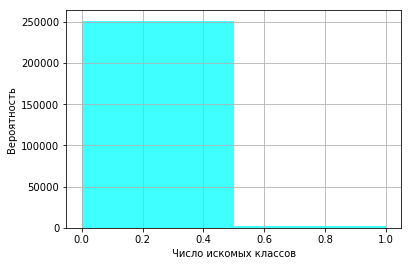

In [36]:
n, bins, patches = plt.hist(y, 2, facecolor='aqua', alpha=0.75)

plt.xlabel('Число искомых классов')
plt.ylabel('Вероятность')
plt.grid(True)

plt.show()

Вывод: искомые классы в обучающей выборке не сбалансированы, большиство классов представлены небольшим количеством сессий. Среднее значение кол-ва сессий на каждый класс равно:

## Продолжительность сессий

Предварительно обработаем выбросы для этого признака. Для этого для всех значений превышающий 95% порог и недостигающих 5% порог приравняем их этим порогам.

In [46]:
def filter_perc(q95, q05, x):
    if x>q95: 
        res = q95 
    elif x<q05: 
        res = q05
    else: 
        res = x
    return res

In [47]:
q95 = additional.session_timespan.quantile(.95)
q05 = additional.session_timespan.quantile(.05)
print (q05,q95)
additional['session_timespan_filtered'] = additional['session_timespan'].apply(lambda x: filter_perc(q95, q05, x))
additional = additional.fillna(0)

1.0 770.0


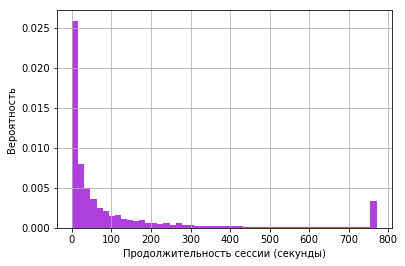

In [48]:
n, bins, patches = plt.hist(additional['session_timespan_filtered'], 50, normed=1, facecolor='darkviolet', alpha=0.75)

plt.xlabel('Продолжительность сессии (секунды)')
plt.ylabel('Вероятность')
plt.grid(True)

plt.show()

Вывод: большиство сессий имеют продолжительность меньше 1.5 минут.

##  Распределение числа уникальных сайтов в сессии

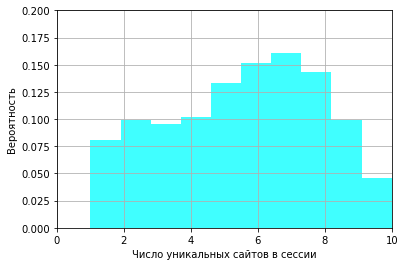

In [49]:
n, bins, patches = plt.hist(additional['#unique_sites'], 10, normed=1, facecolor='aqua', alpha=0.75)

plt.xlabel('Число уникальных сайтов в сессии')
plt.ylabel('Вероятность')
plt.axis([0, 10, 0, 0.2])
plt.grid(True)

plt.show()

Вывод: в среднем число уникальных сайтов в сессии из 10 сайтов составляет 6-7 штук.

## Распределение часа начала сессии

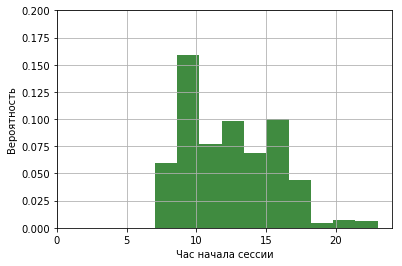

In [50]:
additional['start_hour'] = additional['start_hour'].apply(lambda x: int(x))
plt.hist(additional['start_hour'], 10, normed=1, facecolor='darkgreen', alpha=0.75)

plt.xlabel('Час начала сессии')
plt.ylabel('Вероятность')
plt.axis([0, 24, 0, 0.2])
plt.grid(True)

plt.show()

Выводы:
- В данной выборке отсуствуют сессии с временем начала с 23 до 7 часов утра
- Чаще всего пользователи выходят в интернет утром с 7 до 9, в обед с 13 до 14 и вечером с 15 до 18

## Распределение дня начала сессии

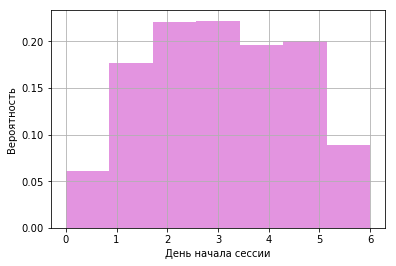

In [51]:
additional['day_of_week'] = additional['day_of_week'].apply(lambda x: int(x))
plt.hist(additional['day_of_week'], 7, normed=1, facecolor='orchid', alpha=0.75)
plt.xlabel('День начала сессии')
plt.ylabel('Вероятность')
plt.grid(True)
plt.show()

Вывод: люди большую часть времени проводят в интернете по будням, кол-во сессий в субботу и воскресение значительно меньше.

## Число сайтов из Топ50 в сессии

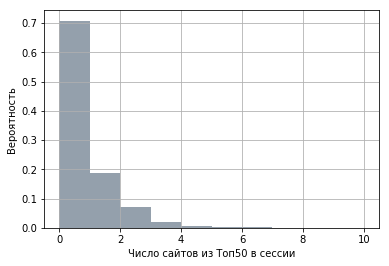

In [52]:
additional['popular_sites'] = additional['popular_sites'].apply(lambda x: int(x))
plt.hist(additional['popular_sites'], 10, normed=1, facecolor='slategrey', alpha=0.75)
plt.xlabel('Число сайтов из Топ50 в сессии')
plt.ylabel('Вероятность')
plt.grid(True)
plt.show()

Вывод: с вероятностью 15-20% в сессии присутствует сайт из Топ50 сайтов в выборке.

## Сезон

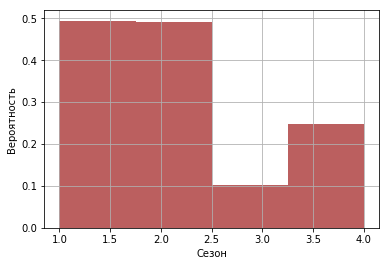

In [53]:
additional['season'] = additional['season'].apply(lambda x: int(x))
plt.hist(additional['season'], 4, normed=1, facecolor='brown', alpha=0.75)
plt.xlabel('Сезон')
plt.ylabel('Вероятность')
plt.grid(True)
plt.show()

Вывод:кол-во сессий осенью значительно меньше, чем в остальные сезоны.

## Let's Machine Learning Begin

Реализуем функции визуализации AUC кривых и записи результатов в файл в формате kaggle.

In [37]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [38]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Подготовим кросс-валидатор, и попробуем с помощью GridSearchCV и вычислить оптимальный классификатор и его параметры

In [39]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Попробуем применить различные алгоритмы классификации с набором параметров по сетке с помощью GridSearchCV
- LogisticRegression
- Linear SVM
- SGDClassifier
- RandomForestClassifier

In [40]:
def search_cv_predict_write(estimator, params_grid, X_train, y_train, X_test, filename, cv=skf):
    grid_searcher = GridSearchCV(estimator, params_grid, scoring = 'roc_auc',  n_jobs = -1, cv=skf)
    grid_searcher.fit(X_train, y_train)

    print(grid_searcher.best_score_)
    print (grid_searcher.best_params_)
    
    test_pred_proba = np.array([*map(lambda x: x[1], grid_searcher.best_estimator_.predict_proba(X_test))])
    write_to_submission_file(test_pred_proba, filename)
    return grid_searcher

## Испытываем LogisticRegression с LogisticRegressionCV

In [41]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [43]:
%%time
estimator = LogisticRegressionCV(random_state=17, n_jobs=-1, cv = skf, Cs = np.linspace(1, 11, 20), scoring = 'roc_auc')
estimator.fit(X_train_sparse_with_new, y)

CPU times: user 8.92 s, sys: 429 ms, total: 9.35 s
Wall time: 2min 27s


In [44]:
test_pred = estimator.predict_proba(X_test_sparse_with_new)
write_to_submission_file(test_pred[:,1], os.path.join(PATH_TO_DATA, 'submission_LogisticRegressionCV.csv'))
#0.94409 on kaggle

## Испытываем LogisticRegression с GridSearchCV

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [46]:
logit = LogisticRegression(C = 55, random_state = 17)
logit_params2 = {'C': np.linspace(1, 5, 20)}

In [47]:
%%time
grid_searcher = search_cv_predict_write(logit, logit_params2, X_train_sparse_with_new, y, X_test_sparse_with_new, 'submission-logistic.txt')

0.839861081638
{'C': 3.9473684210526314}
CPU times: user 32.7 s, sys: 852 ms, total: 33.5 s
Wall time: 6min 41s


## Испытываем SGDClassifier

In [50]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [51]:
sgd_logit = SGDClassifier( loss='log', random_state=17, n_jobs=-1, penalty='l1')
sgd_param_grid = {
    'n_iter':[ 100, 200, 300 ],
    'alpha' : [0.0001, 0.00001],
    'penalty' : ['l1', 'l2'],
    'loss' : ['log']
}

In [52]:
%%time
sgd_grid_searcher = search_cv_predict_write(sgd_logit, sgd_param_grid, X_train_sparse_with_new, y, X_test_sparse_with_new, 'submission-sgd.txt')

0.912720339361
{'alpha': 1e-05, 'loss': 'log', 'n_iter': 300, 'penalty': 'l1'}


/Users/dreshetnikov/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


CPU times: user 41 s, sys: 500 ms, total: 41.5 s
Wall time: 3min 52s


## Испытываем RandomForestClassifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
forest_param_grid = { 
    'n_estimators': [100],
    'max_features': ['auto']
}

In [55]:
%%time
forest_grid_searcher = search_cv_predict_write(forest, forest_param_grid, X_train_sparse_with_new, y, X_test_sparse_with_new, 'submission-forest.txt')

0.969982913182
{'max_features': 'auto', 'n_estimators': 100}
CPU times: user 24min 18s, sys: 5.77 s, total: 24min 23s
Wall time: 18min 14s


## sklearn.ensemble.BaggingClassifier

In [56]:
from sklearn.ensemble import BaggingClassifier

In [57]:
logit = LogisticRegression(C = 1.62, random_state = 17)
bagging = BaggingClassifier(logit, n_jobs = -1)
bagging_params = {
                    'n_estimators': [10],
                 }

In [60]:
%%time
svm_best_estimator = search_cv_predict_write(bagging, bagging_params, X_train_sparse_with_new, y, X_test_sparse_with_new, 'submission-bagging.txt')


0.824125627522
{'n_estimators': 10}


## Лучшая модель

Лучший результат показала модель, которая была натренирована с помощью LogisticRegressionCV. Она показала результат __0.94409__ roc auc. На данный момент это 14ый результат в таблице результатов.

Ник на kaggle: __[YDF & MIPT] Dmitriy Reshetnikov__

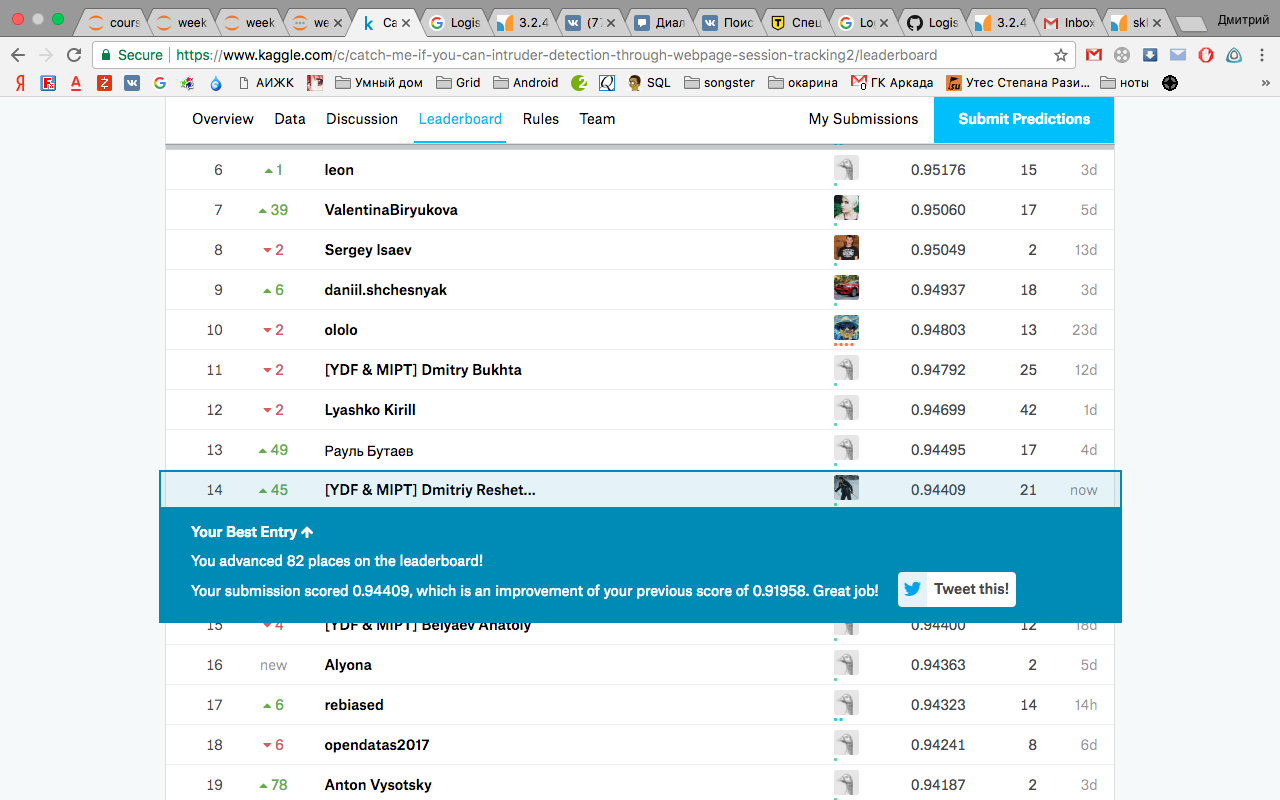

In [74]:
from IPython.display import Image
Image(filename='kaggle_leaderboard.png')

# Выводы

 - В результате данной работы была найдена модель, позволяющая определить злоумышленика по последовательности переходов по сайтам. 
 - Лучшие результаты показала модель построенная с помощью Linear Regression CV классификатора с парамером C = 6.2. Она определяет, что пользователь не тот за кого себя выдает с площадью под кривой ROC AUC 94% (99% на обучающей выборке).
 - Данный результат кажется отличным, но это связано с несбалансированностью классов. Константный метод, получает результат в 0.82.
 - Подходы и опыт, полученные в данной работе можно использовать также в похожих задачах, где действиями пользователя будут не переходы по ссылкам, а другие действия.

# Методы улучшения

- можно попробовать натренировать модель на длинах сессий и размерах смещений других размеров. Для этого нужно будет взять "сырые" данные с kaggle
- можно попробовать нарезать сессии основываясь на времени, скажем, наприме, чтобы длина сессии была не больше 30 минут
